## Hessian Example
### Cubic Lost Function and Taylor Expansion
Here it is shown how to compute the Hessian of a lost function delcared using TensorFlow.
Let us consider the following lost function,
$$ \mathcal{L}(x,y) = 2x^3y^3 $$
$$ \nabla \mathcal{L} (x,y) = \begin{bmatrix}
6x^2y^3\\6x^3y^2
\end{bmatrix}\\
\mathcal{H}(x,y) = \begin{bmatrix}
12 x y^3 & 18x^2y^2\\
18 x^2 y^2 & 12 x^3 y
\end{bmatrix}$$
now thanks to the Taylor expansion the Hessian is used to approximate the lost function.
$$\mathcal{L}(x^*,y^*) = \mathcal{L}(x_0,y_0) + \nabla \mathcal{L}(x_0,y_0)\cdot \begin{bmatrix}\Delta x\\\Delta y\end{bmatrix}+ \begin{bmatrix}\Delta x\\\Delta y\end{bmatrix}\cdot\mathcal{H}(x_0,y_0)\begin{bmatrix}\Delta x\\\Delta y\end{bmatrix}+\mathcal{O}(\max\{\Delta x,\Delta y\}^3)$$

In [1]:
#We import all the library we are gona need
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from numsa.TFHessian import *

In [2]:
#Defining the Loss Function
def Loss(X):
    return 2*X[0]**3*X[1]**3;
#Defining the Hessian class for the above loss function in x
x0 = tf.Variable([1.0,1.0])
H =  Hessian(Loss,x0)

Convergence order 3.160964012145996


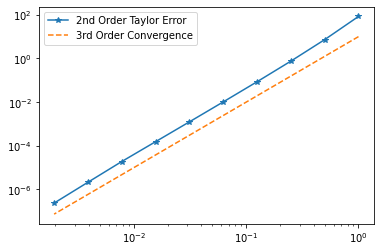

In [3]:
Error = [];
ErrorH = [];
N = 10
for n in range(N):
    h = 1/(2**n);
    ErrorH = ErrorH + [h];
    x = tf.Variable([1.0+h,1.0+h]);
    v = tf.Variable([h,h]);
    Grad, Hv = H.action(v,True)
    err = abs(Loss(x)-Loss(x0)-tf.tensordot(Grad,v,1)
    -0.5*tf.tensordot(v,Hv,1));
    Error = Error + [err];
plt.loglog(ErrorH,Error,"*-")
plt.loglog(ErrorH,[10*h**3 for h in ErrorH],"--")
plt.legend(["2nd Order Taylor Error","3rd Order Convergence"])
order = (tf.math.log(Error[7])-tf.math.log(Error[9]))/(np.log(ErrorH[7])-np.log(ErrorH[9]))
print("Convergence order {}".format(order))

$$\mathcal{H}(1,1) = \begin{bmatrix}
12 & 18\\
18 & 12
\end{bmatrix}, \qquad \lambda_1 = 30 \qquad \lambda_2 = -6$$

In [4]:
H.eig("pi-max") #Power iteration to find the maximum eigenvalue.

<tf.Tensor: shape=(), dtype=float32, numpy=30.000002>

### Very Small Neural Network Built With KERAS

In [5]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from numsa.TFHessian import *

from tqdm.notebook import tqdm

In [6]:
Ord = 1;
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3)
init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)
# Inputs
training_data = np.array([[0,0],[0,1],[1,0],[1,1]], "float32")
# Outputs

training_label = np.array([[0],[1],[1],[0]], "float32")
training_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_label))
model = tf.keras.Sequential([
    tf.keras.layers.Dense(2,input_dim=2, activation='softmax',bias_initializer=init),#2 nodes hidden layer
    tf.keras.layers.Dense(1)
])
def loss_fn(y,x):
    return tf.math.reduce_mean(tf.math.squared_difference(y, x));
def Loss(weights):
    predictions = model(training_data, training=True) #Logits for this minibatch
    # Compute the loss value for this minibatch.
    loss_value = loss_fn(training_label, predictions);
    return loss_value;
for epoch in tqdm(range(100)):
    for step, (x,y) in enumerate(training_dataset):
        if Ord == 2:
            # Compute Hessian and Gradients
            H = Hessian(Loss,model.trainable_weights,"KERAS")
            fullH, grad = H.mat(model.trainable_weights,grad=True);
            #Reshaping the Hessians
            grads = [tf.Variable(grad[0:4].reshape(2,2),dtype=np.float32),
                     tf.Variable(grad[4:6].reshape(2,),dtype=np.float32),
                     tf.Variable(grad[6:8].reshape(2,1),dtype=np.float32),
                     tf.Variable(grad[8].reshape(1,),dtype=np.float32),]
        if Ord == 1:
            with tf.GradientTape() as tape:
                # Run the forward pass of the layer.
                # The operations that the layer applies
                # to its inputs are going to be recorded
                # on the GradientTape.
                labels = model(training_data, training=True)  # Logits for this minibatch
                # Compute the loss value for this minibatch.
                loss_value = loss_fn(training_label, labels)
                # Use the gradient tape to automatically retrieve
                # the gradients of the trainable variables with respect to the loss.
                grads = tape.gradient(loss_value, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
for step, (x,y) in enumerate(training_dataset):
    print("Test {} with data {} produce {} .".format(step,x,tf.math.round(model(np.array([x])))))

  0%|          | 0/100 [00:00<?, ?it/s]

Test 0 with data [0. 0.] produce [[0.]] .
Test 1 with data [0. 1.] produce [[0.]] .
Test 2 with data [1. 0.] produce [[0.]] .
Test 3 with data [1. 1.] produce [[0.]] .


In [7]:
print("Number of trainable layers {}".format(len(model.trainable_weights)))
print("Number of weights trainable per layer 0, {}".format(model.trainable_weights[0].shape))
print("Number of weights trainable per layer 1, {}".format(model.trainable_weights[1].shape))
print("Number of weights trainable per layer 2, {}".format(model.trainable_weights[2].shape))
print("Number of weights trainable per layer 3, {}".format(model.trainable_weights[3].shape))

Number of trainable layers 4
Number of weights trainable per layer 0, (2, 2)
Number of weights trainable per layer 1, (2,)
Number of weights trainable per layer 2, (2, 1)
Number of weights trainable per layer 3, (1,)


0.001604333519935608


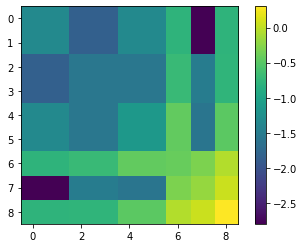

In [10]:
#Function written for parallel
def Loss(weights,comm):
    batches = np.array_split(training_data,comm.Get_size());
    predictions = model(batches[comm.Get_rank()], training=True) #Logits for this minibatch
    # Compute the loss value for this minibatch.
    loss_value = loss_fn(training_label, predictions);
    return loss_value;

#Function written for serial
def Loss(weights):
    predictions = model(training_data, training=True) #Logits for this minibatch
    # Compute the loss value for this minibatch.
    loss_value = loss_fn(training_label, predictions);
    return loss_value;

H = Hessian(Loss,model.trainable_weights,"KERAS")
H.SwitchVerbose(False)
fullH= H.mat();
plt.imshow((np.log10(abs(fullH)+1e-16)))
plt.colorbar()
print(np.min(abs(fullH)))

In [ ]:
w = np.random.rand(9,1)
print((abs(fullH@w-(H.vecprod(w).reshape(9,1)))<1e-6).all())

In [ ]:
_,sigmas,_ = H.RandMatSVD(3,2);
print(sigmas)